<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.patches import Polygon
import seaborn as sns
import scipy as sp
from scipy import signal
from scipy.interpolate import griddata
from datetime import timedelta, datetime

In [3]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch

# Importing Data

## Importing Hourly Resolution Data

### Obtaining Longitudes and Latitudes from All Stations

We start by reading the first two lines of the data file to obtain the longitude and latitude information of the stations. We zip them together into a list of tuples, and add an element to the beginning of this list corresponding to the time.

In [4]:
lon_and_lat = np.genfromtxt('AllStations_temperature_h_2017.dat', delimiter=" ", max_rows=2)
longitudes = lon_and_lat[0][~np.isnan(lon_and_lat[0])]
latitudes = lon_and_lat[1][~np.isnan(lon_and_lat[1])]

indices = list(zip(longitudes, latitudes))
indices.insert(0, "time")

### Reading the Temperature Data

We now read in the temperature data, skipping the first two rows that contain the longitude and latitude information of the stations. The column names of the dataframe are the longitude and latitude tuples created above, and the index column is the timestamps.

In [5]:
df = pd.read_csv('AllStations_temperature_h_2017.dat', sep='\s+', skiprows=[0,1], names=indices, index_col = 'time')
df.head()

,236.554,236.499,236.679,236.607,236.514,236.630,236.523,236.543,236.662,236.304,...,236.641,236.619,236.514,236.357,236.574,236.596,236.676,236.691,236.689,236.451
,48.5745,48.5376,48.4655,48.4608,48.4356,48.5273,48.4529,48.6804,48.4562,48.3891,...,48.4683,48.4744,48.4205,48.6568,48.4533,48.6529,48.4865,48.4623,48.4359,48.4572
time,,,,,,,,,,,,,,,,,,,,,
733408.0000,3.25,1.43,4.21,4.62,3.45,4.44,2.72,3.97,4.68,5.12,...,4.29,4.10,3.01,NaN,4.00,4.81,4.58,NaN,4.87,4.07
733408.0417,3.06,1.38,4.28,4.77,3.46,4.21,2.64,4.15,4.61,4.95,...,4.41,4.30,2.87,NaN,4.15,4.60,4.44,NaN,4.85,4.05
733408.0833,1.90,1.18,4.12,4.70,3.46,4.07,2.64,4.18,4.62,5.11,...,4.24,4.23,2.97,NaN,4.06,4.65,4.47,NaN,4.91,4.02
733408.1250,1.69,0.98,4.20,4.77,3.65,3.67,2.81,4.27,4.71,5.33,...,4.36,4.30,3.10,NaN,4.12,4.75,4.53,NaN,4.97,4.06
733408.1667,2.09,0.93,4.61,4.99,3.90,3.55,3.11,4.29,4.93,5.56,...,4.58,4.53,3.37,NaN,4.25,4.97,4.68,NaN,5.17,4.27


### Changing the Datetimes into Appropriate Timestamps

The Datetimes used in this file are MATLAB datetimes. We use a function to convert each time in the time column to the appropriate timestamp and then change the index column into timestamps.

In [6]:
def matlab_to_python_datetime(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

df.index = [matlab_to_python_datetime(i) for i in df.index]
df.head()

,236.554,236.499,236.679,236.607,236.514,236.630,236.523,236.543,236.662,236.304,...,236.641,236.619,236.514,236.357,236.574,236.596,236.676,236.691,236.689,236.451
,48.5745,48.5376,48.4655,48.4608,48.4356,48.5273,48.4529,48.6804,48.4562,48.3891,...,48.4683,48.4744,48.4205,48.6568,48.4533,48.6529,48.4865,48.4623,48.4359,48.4572
2008-01-01 00:00:00.000000,3.25,1.43,4.21,4.62,3.45,4.44,2.72,3.97,4.68,5.12,...,4.29,4.10,3.01,NaN,4.00,4.81,4.58,NaN,4.87,4.07
2008-01-01 01:00:02.879995,3.06,1.38,4.28,4.77,3.46,4.21,2.64,4.15,4.61,4.95,...,4.41,4.30,2.87,NaN,4.15,4.60,4.44,NaN,4.85,4.05
2008-01-01 01:59:57.120005,1.90,1.18,4.12,4.70,3.46,4.07,2.64,4.18,4.62,5.11,...,4.24,4.23,2.97,NaN,4.06,4.65,4.47,NaN,4.91,4.02
2008-01-01 03:00:00.000000,1.69,0.98,4.20,4.77,3.65,3.67,2.81,4.27,4.71,5.33,...,4.36,4.30,3.10,NaN,4.12,4.75,4.53,NaN,4.97,4.06
2008-01-01 04:00:02.879995,2.09,0.93,4.61,4.99,3.90,3.55,3.11,4.29,4.93,5.56,...,4.58,4.53,3.37,NaN,4.25,4.97,4.68,NaN,5.17,4.27


### Finding the Required Station

These are the coordinates where we wish to measure the temperature. We look for the station nearest to this point.

In [7]:
station_lon = 236.691
station_lat =  48.462

In [8]:
lon_diff = abs(longitudes - station_lon)
lat_diff = abs(latitudes - station_lat)

station_num = list((lon_diff+lat_diff)).index(min(lon_diff+lat_diff))

station_num provides the column number of the data we wish to observe.

### Obtain Winter and Summer Data

In [9]:
winter_start = pd.Timestamp(year=2015, month=12, day=1, hour=0)
winter_end = pd.Timestamp(year=2016, month=3, day=1, hour=0)
summer_start = pd.Timestamp(year=2016, month=6, day=1, hour=0)
summer_end = pd.Timestamp(year=2016, month=9, day=1, hour=0)

winter_data = df[(df.index>winter_start) & (df.index<winter_end)]
summer_data = df[(df.index>summer_start) & (df.index<summer_end)]

In [10]:
winter_data

,236.554,236.499,236.679,236.607,236.514,236.630,236.523,236.543,236.662,236.304,...,236.641,236.619,236.514,236.357,236.574,236.596,236.676,236.691,236.689,236.451
,48.5745,48.5376,48.4655,48.4608,48.4356,48.5273,48.4529,48.6804,48.4562,48.3891,...,48.4683,48.4744,48.4205,48.6568,48.4533,48.6529,48.4865,48.4623,48.4359,48.4572
2015-12-01 01:00:02.879995,NaN,3.37,4.69,4.64,5.19,5.75,4.57,3.65,5.03,5.22,...,5.21,3.44,5.45,2.31,5.38,4.08,5.55,5.44,5.03,3.64
2015-12-01 01:59:57.120005,NaN,3.83,4.06,4.53,5.32,6.33,4.82,3.82,4.27,5.33,...,4.45,3.47,5.62,2.36,5.57,4.22,5.48,5.59,3.96,3.82
2015-12-01 03:00:00.000000,NaN,3.93,4.28,5.16,5.44,6.42,5.00,3.96,4.64,4.75,...,4.64,4.02,5.77,2.59,5.90,5.19,5.66,5.90,4.14,3.52
2015-12-01 04:00:02.879995,NaN,4.50,4.83,5.66,5.33,6.50,4.85,4.52,5.42,4.57,...,5.36,4.10,5.68,2.73,5.99,6.38,6.12,6.16,5.33,4.08
2015-12-01 04:59:57.120005,NaN,4.86,5.62,6.01,5.66,7.00,5.16,5.13,6.19,4.84,...,6.37,4.60,5.93,2.89,6.36,5.77,6.44,6.40,6.40,4.06
2015-12-01 06:00:00.000000,NaN,5.12,6.31,6.33,5.96,7.25,5.37,5.61,6.64,5.54,...,6.83,4.86,6.14,3.20,6.71,5.32,6.78,6.78,7.02,4.58
2015-12-01 07:00:02.879995,NaN,5.18,6.78,6.67,6.10,7.70,5.61,5.53,6.97,5.85,...,7.31,5.30,6.20,3.52,6.97,5.52,7.03,7.02,7.20,4.53
2015-12-01 07:59:57.120005,5.22,5.52,7.33,7.20,6.61,7.97,6.10,6.07,7.34,6.39,...,7.70,5.75,6.63,3.64,7.42,5.71,7.35,7.37,7.81,5.75
2015-12-01 09:00:00.000000,5.21,5.69,8.15,7.79,7.18,8.05,6.66,6.44,7.99,7.24,...,8.24,6.46,7.44,4.14,8.05,6.18,7.89,8.10,8.75,6.05


## Look at Missing Data

**Winter Data**

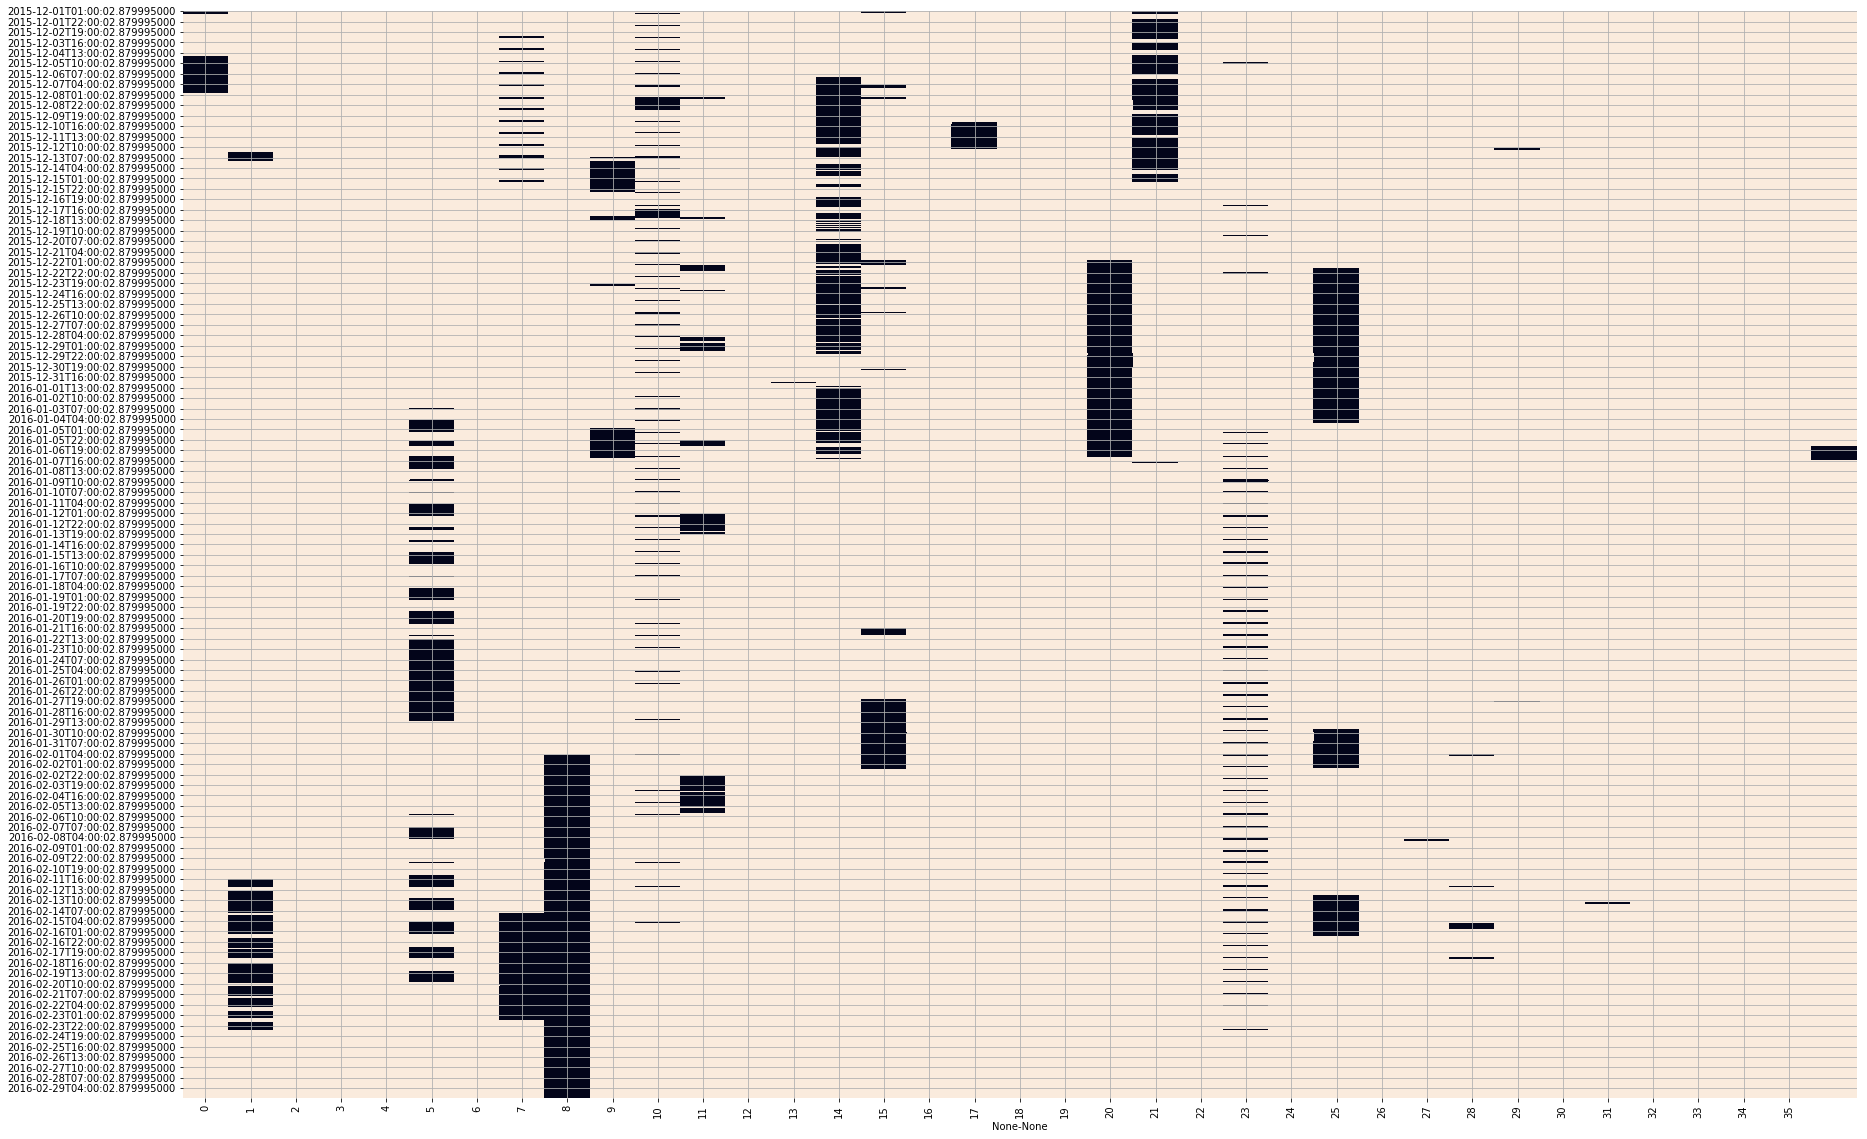

In [11]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~winter_data.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

**Summer Data**

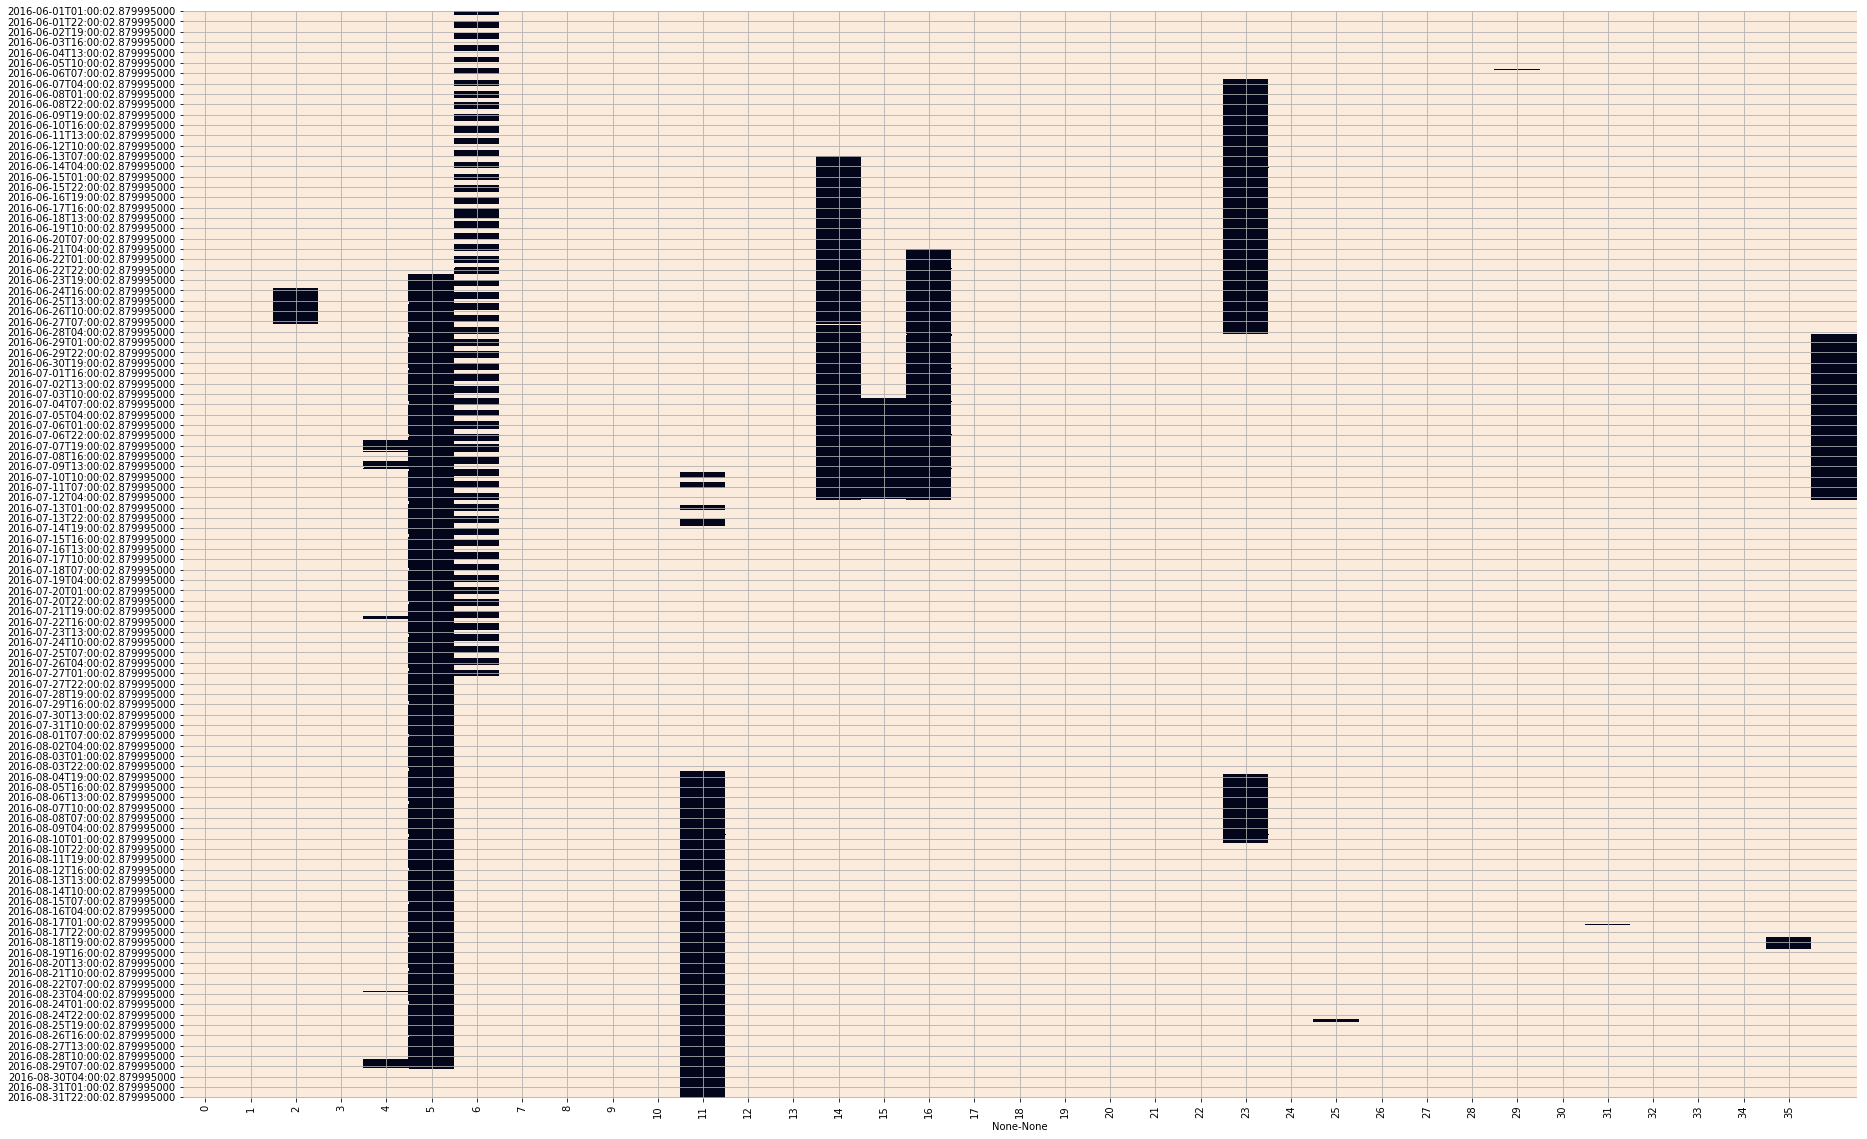

In [12]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~summer_data.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

## Remove the Stations with Lots of Missing Data and Interpolate the Others

In [13]:
winter_removed = [0, 1, 5, 7, 8, 9, 11, 14, 15, 17, 20, 21, 25]
summer_removed = [2, 5, 6, 11, 14, 15, 16, 23, 36]

winter_filt = winter_data.drop(winter_data.columns[winter_removed],axis=1)
summer_filt = summer_data.drop(summer_data.columns[summer_removed],axis=1)

Plot the new missing data.

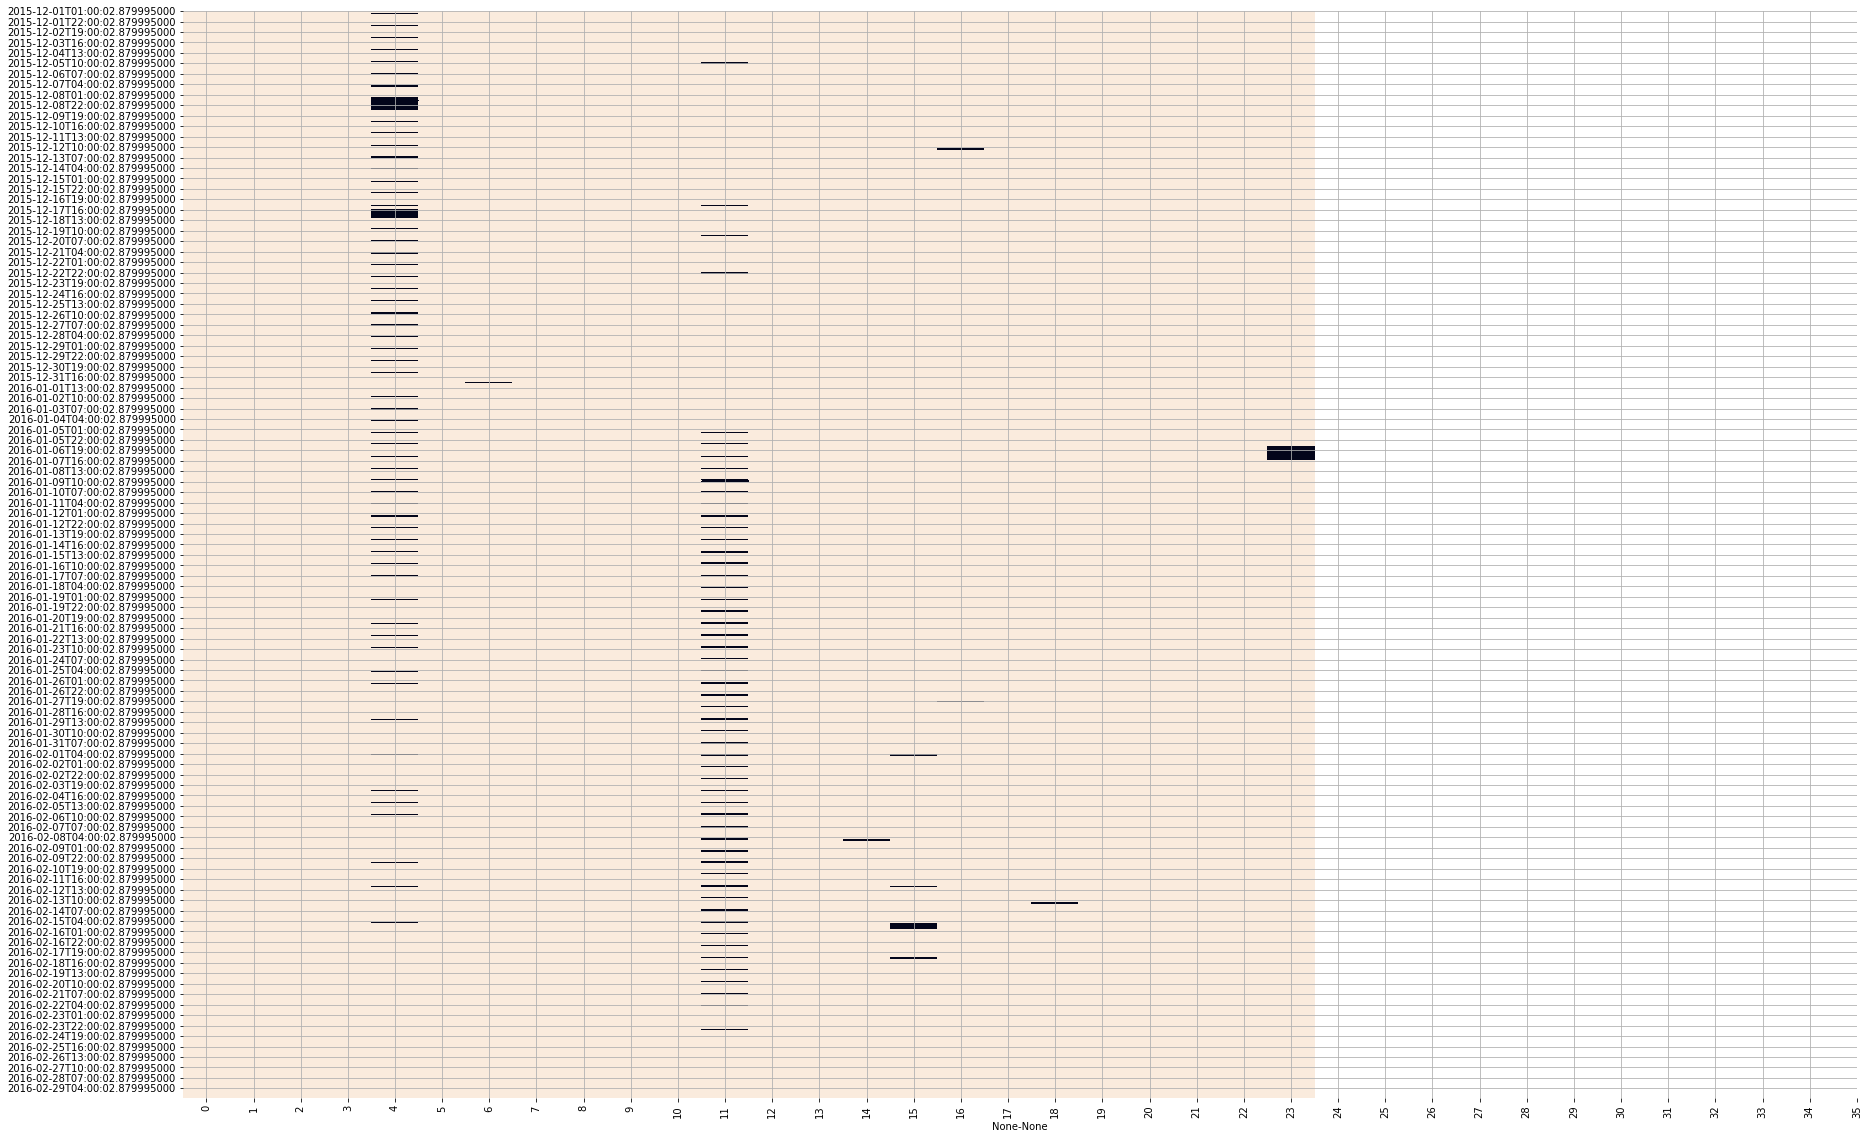

In [14]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~winter_filt.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

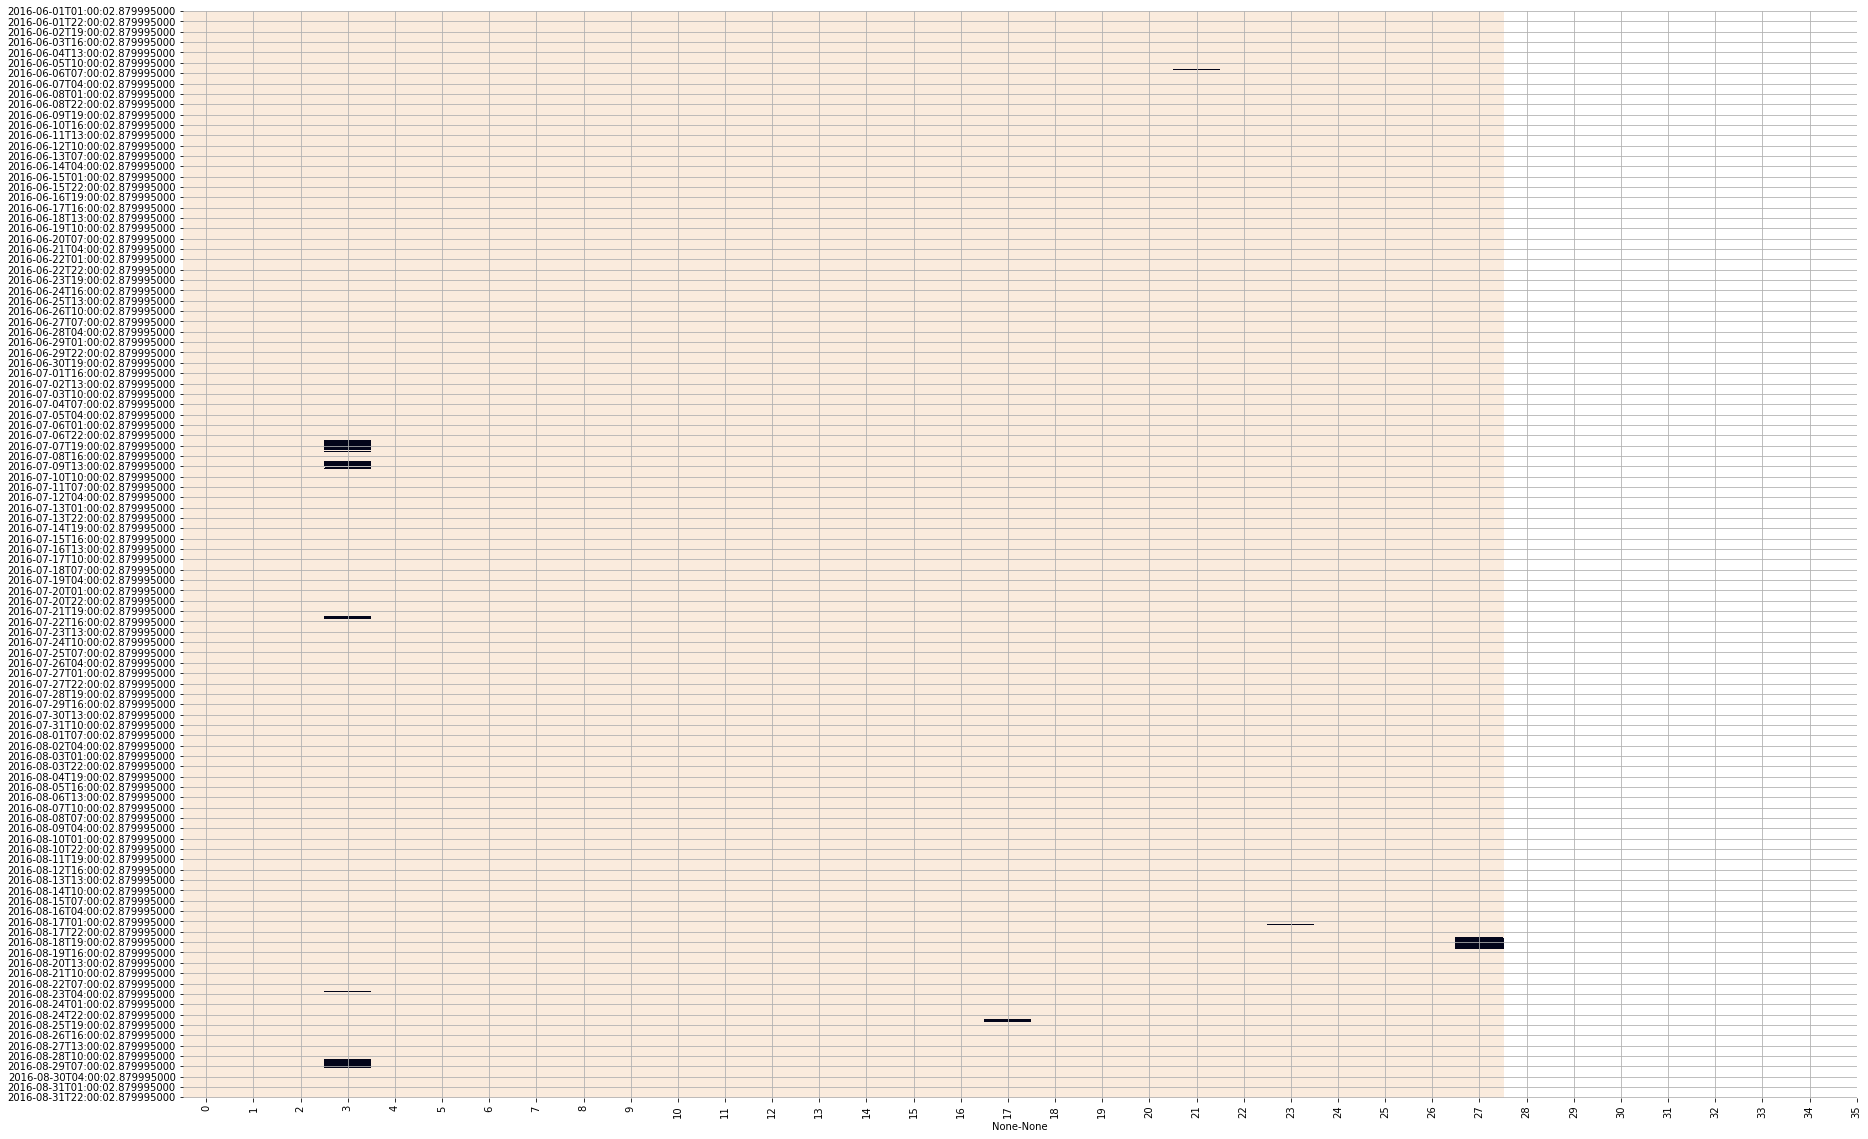

In [15]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~summer_filt.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

## Now Interpolate the DataFrames

In [16]:
winter_df = winter_filt.interpolate(method='cubic', axis=0)
summer_df = summer_filt.interpolate(method='cubic', axis=0)

In [17]:
lons_and_lats = np.array(winter_df.columns)
winter_lons = np.array(list(zip(*lons_and_lats))[0])
winter_lats = np.array(list(zip(*lons_and_lats))[1])

lons_and_lats = np.array(summer_df.columns)
summer_lons = np.array(list(zip(*lons_and_lats))[0])
summer_lats = np.array(list(zip(*lons_and_lats))[1])

## Coastline Map and Island Mapping

Get the values for the coastline. The init arrays are used for when we draw a polygon over the water (otherwise we'd draw a polygon over the island).

In [18]:
coast_array = pd.read_csv('Coast.dat.txt', sep='\s+', names=['lon', 'lat'])
coast_lon_init = np.array([236, 236.8, 236.8])
coast_lat_init = np.array([48.3, 48.3, 48.999])

Get array of coastline.

In [19]:
coast_lon = coast_array['lon'].values+360
coast_lat = coast_array['lat'].values

Use to draw polygon of water

In [20]:
water_poly_lon = np.concatenate((coast_lon_init, coast_lon))
water_poly_lat = np.concatenate((coast_lat_init, coast_lat))

Lon and Lat limits for the area we are concerned with

# Look for Eigenmodes

In [21]:
interp = 'linear'
cmap = cm.bwr
vmin = -0.4
vmax = 0.6

## Winter

Create a meshgrid

In [22]:
Nx = 200
Ny = 100

xx_grid = np.linspace(min(winter_lons), max(winter_lons), Nx)
yy_grid = np.linspace(min(winter_lats), max(winter_lats), Ny)
X_grid, Y_grid = np.meshgrid(xx_grid, yy_grid)

Get covariance matrix and eigenmodes of the covariance matrix

$$C\vec{e}_k = \mu_k \vec{e}_k $$

Note that 

$$\vec{x}(t) = \sum_k \alpha_k(t) \vec{e}_k $$

where

$$\langle \alpha_k \alpha_j \rangle = \mu_k \delta_{jk}$$

In [43]:
C = (winter_df-winter_df.mean()).cov()
eig_vals, eig_vecs = np.linalg.eigh(C)
eig_vals_norm = eig_vals/sum(eig_vals)

In [44]:
np.sqrt(eig_vals[-1])

13.229733871348007

Create the points where the stations are and interpolate the data.

In [24]:
points = np.array(list(zip(winter_lons, winter_lats)))
mode1 = eig_vecs[:,-1]
mode2 = eig_vecs[:,-2]
mode3 = eig_vecs[:,-3]
mode4 = eig_vecs[:,-4]

mode1_interp = griddata(points, mode1, (X_grid, Y_grid), method=interp)
mode2_interp = griddata(points, mode2, (X_grid, Y_grid), method=interp)
mode3_interp = griddata(points, mode3, (X_grid, Y_grid), method=interp)
mode4_interp = griddata(points, mode4, (X_grid, Y_grid), method=interp)

Plot

### Basic Plot

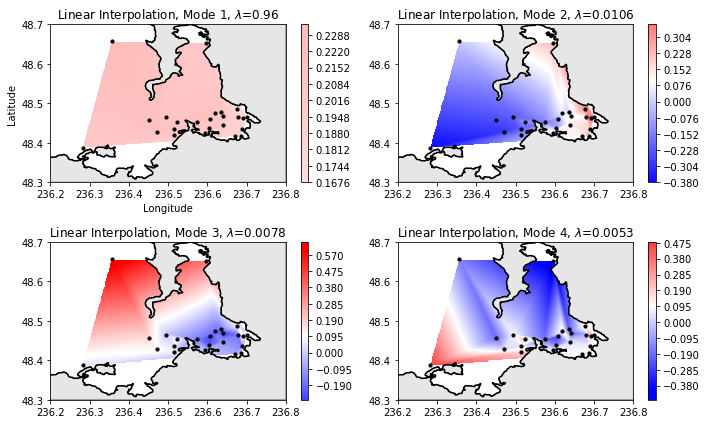

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, mode1_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs2 = ax[0][1].contourf(X_grid, Y_grid, mode2_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs3 = ax[1][0].contourf(X_grid, Y_grid, mode3_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs4 = ax[1][1].contourf(X_grid, Y_grid, mode4_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)

[a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
[a.scatter(winter_lons, winter_lats, c='k', s=10) for a in ax.ravel()]

for a in ax.ravel():
    poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
    a.add_patch(poly)

ax[0][0].set_xlabel('Longitude')
ax[0][0].set_ylabel('Latitude')

ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

[a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
[a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

fig.colorbar(cs1, ax=ax[0][0])
fig.colorbar(cs2, ax=ax[0][1])
fig.colorbar(cs3, ax=ax[1][0])
fig.colorbar(cs4, ax=ax[1][1])

fig.tight_layout()

plt.show()

We can also find the $\alpha$ values and plot actual temperature distributions. This is assuming, of course, that the alpha values don't change throughout the winter (ASSUMPTION).

In [26]:
temp1_interp = mode1_interp * np.sqrt(eig_vals[-1])
temp2_interp = mode2_interp * np.sqrt(eig_vals[-2])
temp3_interp = mode3_interp * np.sqrt(eig_vals[-3])
temp4_interp = mode4_interp * np.sqrt(eig_vals[-4])

### Temperature Plot

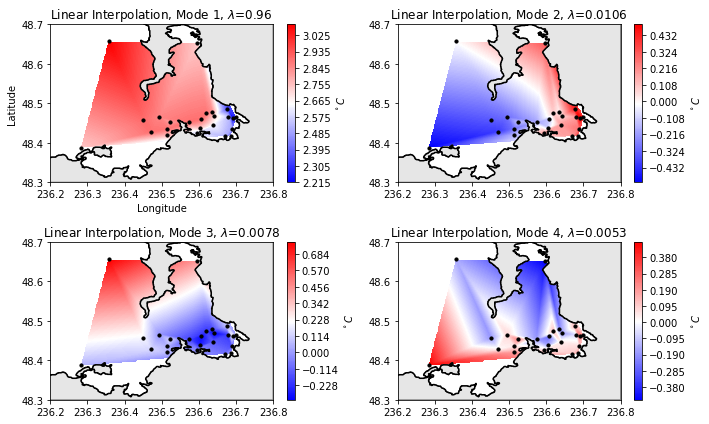

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, temp1_interp, 200, cmap=cmap)
cs2 = ax[0][1].contourf(X_grid, Y_grid, temp2_interp, 200, cmap=cmap)
cs3 = ax[1][0].contourf(X_grid, Y_grid, temp3_interp, 200, cmap=cmap)
cs4 = ax[1][1].contourf(X_grid, Y_grid, temp4_interp, 200, cmap=cmap)

[a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
[a.scatter(winter_lons, winter_lats, c='k', s=10) for a in ax.ravel()]

for a in ax.ravel():
    poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
    a.add_patch(poly)

ax[0][0].set_xlabel('Longitude')
ax[0][0].set_ylabel('Latitude')

ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

[a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
[a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

fig.colorbar(cs1, ax=ax[0][0], label='$^\circ C$')
fig.colorbar(cs2, ax=ax[0][1], label='$^\circ C$')
fig.colorbar(cs3, ax=ax[1][0], label='$^\circ C$')
fig.colorbar(cs4, ax=ax[1][1], label='$^\circ C$')

fig.tight_layout()

plt.show()

## Summer

Create a meshgrid.

In [28]:
Nx = 200
Ny = 100

xx_grid = np.linspace(min(summer_lons), max(summer_lons), Nx)
yy_grid = np.linspace(min(summer_lats), max(summer_lats), Ny)
X_grid, Y_grid = np.meshgrid(xx_grid, yy_grid)

Get covariance matrix and eigenmodes.

In [40]:
C = summer_df.cov()
eig_vals, eig_vecs = np.linalg.eigh(C)
eig_vals_norm = eig_vals/sum(eig_vals)

In [41]:
np.sqrt(eig_vals[-1])

20.75618020303825

Create points where stations are and interpolate the data.

In [30]:
points = np.array(list(zip(summer_lons, summer_lats)))
mode1 = eig_vecs[:,-1]
mode2 = eig_vecs[:,-2]
mode3 = eig_vecs[:,-3]
mode4 = eig_vecs[:,-4]

mode1_interp = griddata(points, mode1, (X_grid, Y_grid), method=interp)
mode2_interp = griddata(points, mode2, (X_grid, Y_grid), method=interp)
mode3_interp = griddata(points, mode3, (X_grid, Y_grid), method=interp)
mode4_interp = griddata(points, mode4, (X_grid, Y_grid), method=interp)

Plot

### Basic Plot

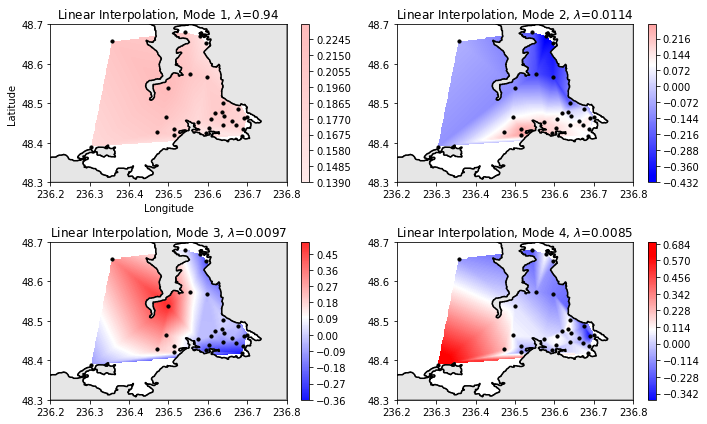

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, mode1_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs2 = ax[0][1].contourf(X_grid, Y_grid, mode2_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs3 = ax[1][0].contourf(X_grid, Y_grid, mode3_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs4 = ax[1][1].contourf(X_grid, Y_grid, mode4_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)

[a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
[a.scatter(summer_lons, summer_lats, c='k', s=10) for a in ax.ravel()]

for a in ax.ravel():
    poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
    a.add_patch(poly)

ax[0][0].set_xlabel('Longitude')
ax[0][0].set_ylabel('Latitude')

ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

[a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
[a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

fig.colorbar(cs1, ax=ax[0][0])
fig.colorbar(cs2, ax=ax[0][1])
fig.colorbar(cs3, ax=ax[1][0])
fig.colorbar(cs4, ax=ax[1][1])

fig.tight_layout()

plt.show()

In [32]:
temp1_interp = mode1_interp * np.sqrt(eig_vals[-1])
temp2_interp = mode2_interp * np.sqrt(eig_vals[-2])
temp3_interp = mode3_interp * np.sqrt(eig_vals[-3])
temp4_interp = mode4_interp * np.sqrt(eig_vals[-4])

### Temperature Plot

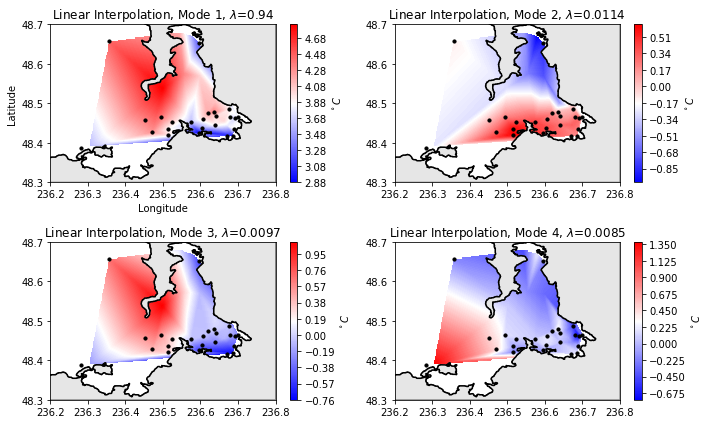

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, temp1_interp, 200, cmap=cmap)
cs2 = ax[0][1].contourf(X_grid, Y_grid, temp2_interp, 200, cmap=cmap)
cs3 = ax[1][0].contourf(X_grid, Y_grid, temp3_interp, 200, cmap=cmap)
cs4 = ax[1][1].contourf(X_grid, Y_grid, temp4_interp, 200, cmap=cmap)

[a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
[a.scatter(winter_lons, winter_lats, c='k', s=10) for a in ax.ravel()]

for a in ax.ravel():
    poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
    a.add_patch(poly)

ax[0][0].set_xlabel('Longitude')
ax[0][0].set_ylabel('Latitude')

ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

[a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
[a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

fig.colorbar(cs1, ax=ax[0][0], label='$^\circ C$')
fig.colorbar(cs2, ax=ax[0][1], label='$^\circ C$')
fig.colorbar(cs3, ax=ax[1][0], label='$^\circ C$')
fig.colorbar(cs4, ax=ax[1][1], label='$^\circ C$')

fig.tight_layout()

plt.show()